# Шаг 1. Откроем файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math as mth
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


# Шаг 2. Подготовка данных

Заменим названия столбцов

In [3]:
data.columns = ['event_name', 'device_id', 'event_date', 'experiment_id']

Проверим пропуски и типы данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   device_id      244126 non-null  int64 
 2   event_date     244126 non-null  int64 
 3   experiment_id  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
#Откорректируем типы данных

data['event_date'] = pd.to_datetime(data['event_date'], unit='s')
data['device_id'] = data['device_id'].astype(str)
data['experiment_id'] = data['experiment_id'].astype(str)

In [6]:
# Проверим наличие дубликатов
data.duplicated().sum()

413

In [7]:
# Удалим дубликаты
data = data.drop_duplicates()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     243713 non-null  object        
 1   device_id      243713 non-null  object        
 2   event_date     243713 non-null  datetime64[ns]
 3   experiment_id  243713 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 9.3+ MB


Добавим столбец даты и времени

In [9]:
data['date'] = data['event_date'].dt.date

In [10]:
data.head()

,event_name,device_id,event_date,experiment_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим не пересекаются ли пользователи в группах для чистоты тестирования.

In [11]:
data.groupby('device_id')['experiment_id'].nunique().reset_index().query('experiment_id > 1')

,device_id,experiment_id


Пользователи не пересекаются в группах

# Шаг 3. Изучаем и проверяем данные

In [12]:
len(data['event_name'].value_counts())

5

В логе всего пять вариантов событий

In [13]:
len(data['device_id'].value_counts())

7551

В логе зарегистрировано 7551 девайс

In [14]:
events = data.pivot_table(index='device_id',values='event_name',aggfunc='count')
avg_events = round(events['event_name'].mean(), 1)
avg_events

32.3

В среднем 32 события приходится на пользователя

In [15]:
data['date'].min()

datetime.date(2019, 7, 25)

In [16]:
data['date'].max()

datetime.date(2019, 8, 7)

Максимальная дата - 07.08.2019, минимальная дата - 25.07.2019

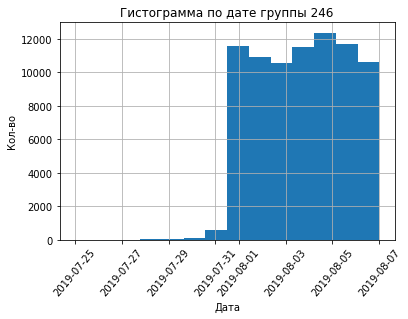

In [17]:
group246 = data.query('experiment_id == "246"')
group246['date'].hist(bins = 14).set_title('Гистограмма по дате группы 246')
plt.xlabel("Дата")
plt.ylabel("Кол-во")
plt.xticks(rotation=50) 
plt.show()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

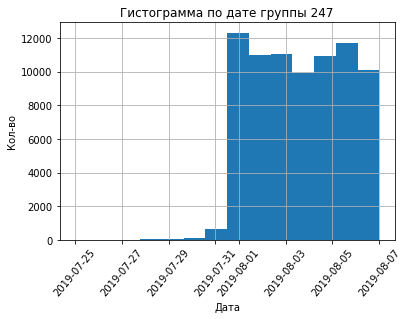

In [18]:
group247 = data.query('experiment_id == "247"')
group247['date'].hist(bins = 14).set_title('Гистограмма по дате группы 247')
plt.xlabel("Дата")
plt.ylabel("Кол-во")
plt.xticks(rotation=50) 
plt.show()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

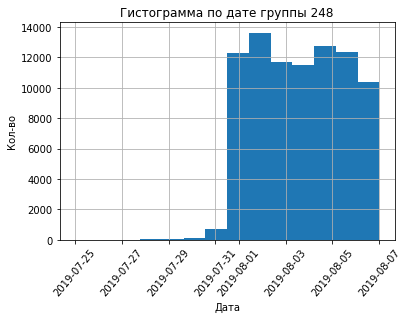

In [19]:
group248 = data.query('experiment_id == "248"')
group248['date'].hist(bins = 14).set_title('Гистограмма по дате группы 248')
plt.xlabel("Дата")
plt.ylabel("Кол-во")
plt.xticks(rotation=50) 
plt.show()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

По гистограмме видно, что до 01.08.201 совершается очень мало событий. Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов.

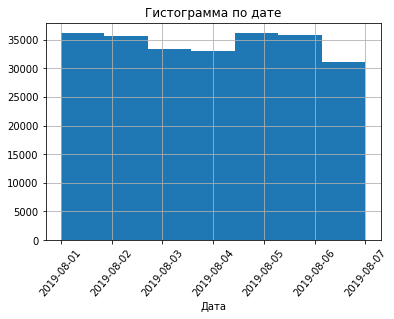

In [20]:
data['date'] = pd.to_datetime(data['date'])
data_new_data = data.query('date > "2019-07-31"')
data_new_data['date'].hist(bins = 7).set_title('Гистограмма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

Посмотрим, сколько событий было потеряно после фильтрации данных.

In [21]:
data_old_data = data.query('date <= "2019-07-31"')
len(data_old_data['event_name'])

2826

Теперь посмотрим, сколько пользователей потеряно при фильтрации данных.

In [22]:
devices_lost = 0
for row in data_new_data:
    if row not in data_old_data['device_id'].unique():
        devices_lost +=1 
print('Было потеряно', devices_lost, 'пользователей')

Было потеряно 5 пользователей


Проверим, что есть пользователи из всех трёх экспериментальных групп

In [23]:
data_new_data.groupby('experiment_id').agg({'device_id': 'nunique'})

,device_id
experiment_id,
246,2484
247,2513
248,2537


Распределение по группам +/- на одном и том же уровне

# Шаг 4. Изучим воронку событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [24]:
data_new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [25]:
data_events = data_new_data.pivot_table(index='event_name',values='device_id',aggfunc='nunique').sort_values(by = 'device_id', ascending = False)
data_events.drop(['Tutorial'], inplace=True)
display(data_events)

,device_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [26]:
funnel = (data_new_data.
          groupby('event_name').
          agg({'device_id': 'nunique'}).
          reset_index().
          rename(columns={'device_id' : 'total_users'}).
          sort_values(by='total_users', ascending=False))
funnel['percent'] = funnel['total_users'] / data['device_id'].nunique() * 100
funnel

,event_name,total_users,percent
1,MainScreenAppear,7419,98.251887
2,OffersScreenAppear,4593,60.826381
0,CartScreenAppear,3734,49.450404
3,PaymentScreenSuccessful,3539,46.867965
4,Tutorial,840,11.124354


Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
Предположительно, воронка продаж следующая:

1. Пользователь видит главный экран сайт
2. Пользователь переходит на нужный ему товар
3. Пользователь добавляет товар в корзину и переходит далее в нее
4. Пользователь оплачивает товар 

Дополнительное событие - это обучение. Возможно, учат оплачивать заказ или пользоваться сайтом, но доля этого события маленькая, поэтому при расчете воронки его можно не учитывать.

Посчитаем по воронке событий, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [27]:
users = data.pivot_table(
    index='device_id', 
    columns='event_name', 
    values='event_date',
    aggfunc='min')

print('Посетителей всего:', 
      '({:.1%})'.format(users['MainScreenAppear'].count() / users['MainScreenAppear'].count() ))
print('Просмотрели Каталог в % от предыдущего шага:', 
      '({:.1%})'.format(users['OffersScreenAppear'].count() / users['MainScreenAppear'].count() ))
print('Просмотрели Карточку товара в % от предыдущего шага:', 
      '({:.1%})'.format(users['CartScreenAppear'].count() / users['OffersScreenAppear'].count()))
print('Оплатили в % от предыдущего шага:',
      '({:.1%})'.format(users['PaymentScreenSuccessful'].count() / users['CartScreenAppear'].count()))


Посетителей всего: (100.0%)
Просмотрели Каталог в % от предыдущего шага: (62.0%)
Просмотрели Карточку товара в % от предыдущего шага: (81.3%)
Оплатили в % от предыдущего шага: (94.6%)


Было подсчитано, какой процент пользователей проходит на каждый из этапов воронки, от предыдущего шага. На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей.

К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей. Возможно главный экран сайта не самый удобный для пользователей, или имеются другие проблемы. Наименее популярным событием в воронке продаж,как и следовало ожидать, событие перехода к оплате. Но если смотреть на конверсию, то большой процент пользователей теряется при переходе от главного экрана к экрану с предложением.

In [28]:
 round(data_events['device_id'].iloc[3]/data_events['device_id'].iloc[0], 2)*100

48.0

48% пользователей доходит до оплаты товара

# Шаг 5. Изучите результаты эксперимента

In [29]:
data_new_data_groups = data_new_data.pivot_table(index='experiment_id',values='device_id',aggfunc='nunique')
display(data_new_data_groups)

,device_id
experiment_id,
246,2484
247,2513
248,2537


В эксперементальной группе 246 - 2484 пользовтеля, в 247 - 2513, в 248 - 2537

Проверим, находят ли статистические критерии разницу между выборками 246 и 247

Сделам таблицу с числом уникальных пользователей по событиям и контрольным группам

In [30]:
data_voronka = data_new_data.pivot_table(index='experiment_id',columns = 'event_name', values='device_id',aggfunc='nunique')
del data_voronka['Tutorial']
data_voronka['Total'] = [data_new_data_groups['device_id'][0], data_new_data_groups['device_id'][1], data_new_data_groups['device_id'][2]]
display(data_voronka)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


Напишем функцию для проверки гипотез

In [31]:
def return_hypothesis_test (success, users, alpha):
   
    p1 = success[0] / users[0]
    p2 = success[1] / users[1]
 
    p_combined = (success[0] + success[1]) / (users[0] + users[1])
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/users[0] + 1/users[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

Напишем функцию, которая на входе получает порядковый номер группы в таблице и параметр альфа, и возвращает результаты проверки гипотез

In [32]:
def test_A (group1, group2, alpha):
    alpha_test = alpha
    count_users = ([data_voronka['Total'][group1], data_voronka['Total'][group2]])
    count_MainScreenAppear = ([data_voronka['MainScreenAppear'][group1], data_voronka['MainScreenAppear'][group2]])
    count_OffersScreenAppear = ([data_voronka['OffersScreenAppear'][group1], data_voronka['OffersScreenAppear'][group2]])
    count_CartScreenAppear = ([data_voronka['CartScreenAppear'][group1], data_voronka['CartScreenAppear'][group2]])
    count_PaymentScreenSuccessful = ([data_voronka['PaymentScreenSuccessful'][group1], data_voronka['PaymentScreenSuccessful'][group2]])
    
    print('Результаты теста по долям count_users и count_MainScreenAppear для групп')
    return_hypothesis_test(count_MainScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_OffersScreenAppear и count_users для групп')
    return_hypothesis_test(count_OffersScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_users и count_CartScreenAppear для групп')
    return_hypothesis_test(count_CartScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп')
    return_hypothesis_test(count_PaymentScreenSuccessful, count_users, alpha_test)

Введем основную и альтернативные гипотезы для всех попарных сравнений:

1. Нулевая гиптеза: доли в двух выборках равны
2. Альтернративная гипотеза: доли в двух выборках не равны

 Сделаем проверку контрольных групп А/A

In [33]:
test_A (0, 1, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между группами 246 и 247 ни по одному событию нет статистически значимого отличия при заданном уровне значимости в 0.05,самым популярным событием является показ главного экрана сайта. С этого и начинается воронка продаж.
Приступим к A/B-тестированию.

Соединим две контрольные группы в группу 249

In [34]:
data_voronka.loc['249'] = [data_voronka['CartScreenAppear'][0]+data_voronka['CartScreenAppear'][1] , data_voronka['MainScreenAppear'][0]+data_voronka['MainScreenAppear'][1], data_voronka['OffersScreenAppear'][0]+data_voronka['OffersScreenAppear'][1], data_voronka['PaymentScreenSuccessful'][0]+data_voronka['PaymentScreenSuccessful'][1], data_voronka['Total'][0]+data_voronka['Total'][1]]
display(data_voronka)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
249,2504,4926,3062,2358,4997


Сделаем проверку групп А1/B (246 и 248)

In [35]:
test_A (0, 2, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При заданном уровне значимости в 0.05 у нас нет оснований считать группы 246 и 248 разными.

Сделаем проверку групп А2/B (247 и 248)

In [36]:
test_A (1, 2, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При заданном уровне значимости различия между группами 247 и 248 не обнаружились.

In [37]:
test_A (3, 2, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Из проведенных проверок статистически значимой разницы можем сделать вывод, что изменение шрифтов никак не повлияло на поведение пользователей контрольных групп.

Сделаем проверку гипотез между группами при уровне значимости 0.1

In [38]:
test_A (0, 1, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [39]:
test_A (0, 2, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [40]:
test_A (1, 2, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [41]:
test_A (2, 3, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между первой контрольной группой 246 и группой с измененными шрифтами 248 значимых различий нет. А вот между группами 246 и 248 есть значимая разница в доле пользоватей, перешедших к странице корзины. Значимой разницы в переходах объединенной контрольной группы с 248-ой группой нет.

Посчитаем уровень альфа с поправкой Шикада

In [49]:
alpha_shidaka = 1 - (1 - 0.05)**(1/16)
alpha_shidaka

0.0032006977101884937

In [59]:
test_A (0, 2,alpha_shidaka)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [56]:
test_A (1, 2, alpha_shidaka)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [57]:
test_A (3, 2, alpha_shidaka)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [60]:
test_A (0, 1, alpha_shidaka)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Наблюдаемые данные не подтверждают наличие разницы между группами.

# Выводы

В результате исследования были проанализированы поведение покупателей на основании логов пользователей, а так же, результаты А/А/В-теста. После предобработки данных было рассмотрено поведение 7419-ти пользователей мобильного приложения.
Далее, был проанализирован результат А/А/В-эксперимента(изменение шрифта во всем приложении), для этого были ипользованы логи событий за неделю
Согласно предложенному процессу, нам нужно было сопоставить доли пользователей по каждому событию между:

контрольными группами 246 и 247;
каждой из контрольной группы по отдельности и экспериментальной (246-248 и 247-248);
объединенной контрольной группой и экспериментальной (246+247 и 248).
Множесто А/В-тестов, проведённых по каждому из событий, не обнаружили статистически значимой разницы между группами. Т.е. изменение шрифтов во всём приложении на поведение пользователей не повлияло.